In [30]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

In [7]:
sns.set()

In [5]:
df = pd.read_csv('final_data.csv')

<Axes: xlabel='Year'>

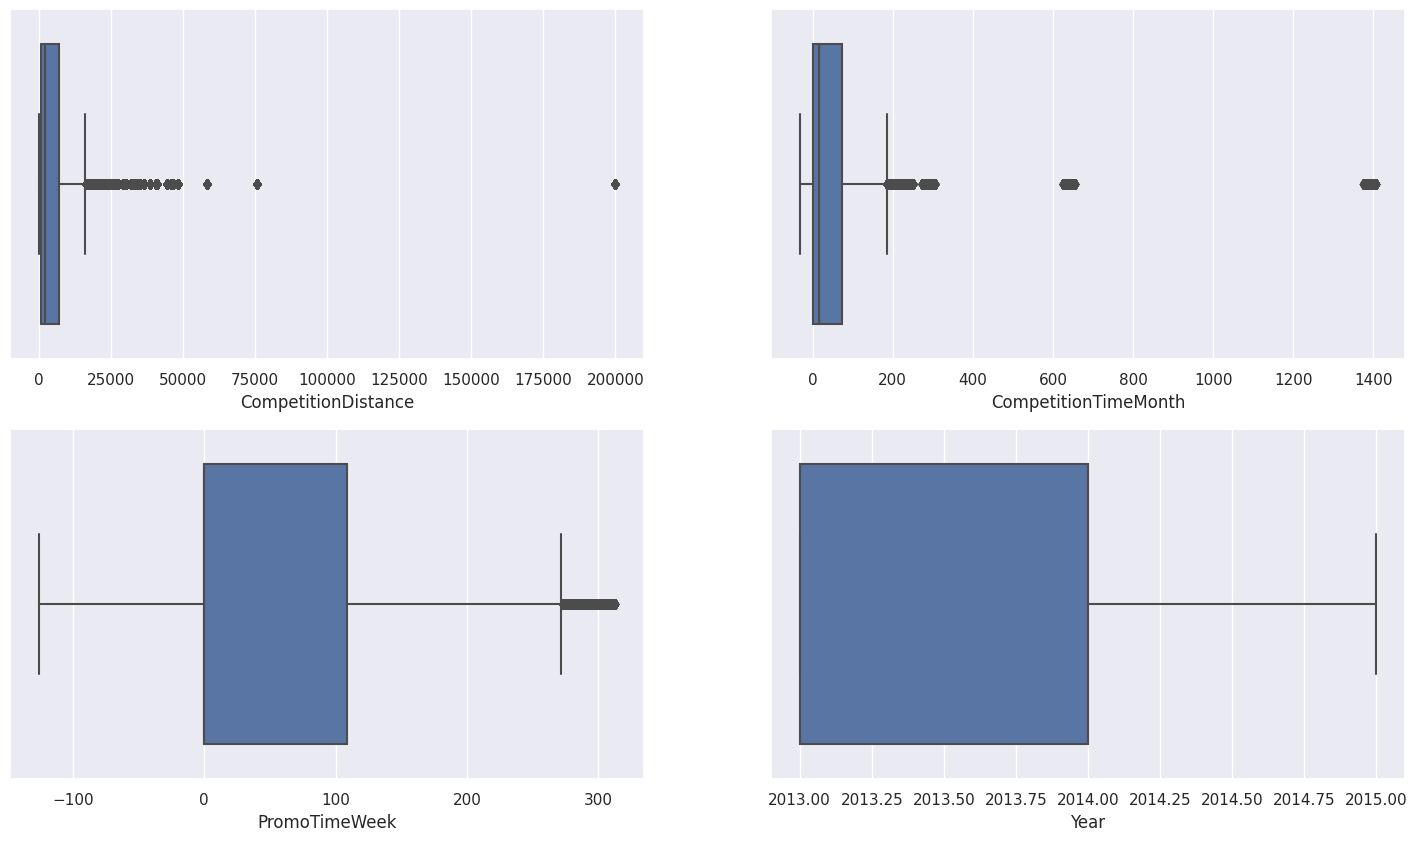

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

 
sns.boxplot(ax=axes[0,0], data=df, x='CompetitionDistance')
sns.boxplot(ax=axes[0,1], data=df, x='CompetitionTimeMonth')
sns.boxplot(ax=axes[1,0], data=df, x='PromoTimeWeek')
sns.boxplot(ax=axes[1,1], data=df, x='Year')

Vamos usar o RobustScaler para as variáveis CompetitionDistance e CompetitionTimeMonth devido seus outliers.

Vamos usar o Minmax para o PromoTimeWeek e Year devido a estas duas variáveis não terem outliers relevantes.

### Aplicando Scaler

In [25]:
rs = RobustScaler()

In [28]:
minmax = MinMaxScaler()

In [26]:
df['CompetitionDistance'] = rs.fit_transform(df[['CompetitionDistance']].values)
df['CompetitionTimeMonth'] = rs.fit_transform(df[['CompetitionTimeMonth']].values)

In [29]:
df['PromoTimeWeek'] = minmax.fit_transform(df[['PromoTimeWeek']].values)
df['Year'] = minmax.fit_transform(df[['Year']].values)

### Encoding

In [31]:
# StateHoliday - One Hot Encoding
df = pd.get_dummies( df, prefix=['StateHoliday'], columns=['StateHoliday'] )
# StoreType - Label Encoding
le = LabelEncoder()
df['StoreType'] = le.fit_transform( df['StoreType'] )

# Assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df['Assortment'] = df['Assortment'].map( assortment_dict )

In [32]:
df.head()

,Store,DayOfWeek,Date,Sales,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek,StateHoliday_Christmas,StateHoliday_EasterHoliday,StateHoliday_PublicHoliday,StateHoliday_RegularDay
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


Transformação de grandeza para a variável resposta Sales

In [34]:
df['Sales'] = np.log1p(df['Sales'])

Transformação de natureza cíclica

In [35]:
# day of week
df['DayOfWeekSin'] = df['DayOfWeek'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df['day_of_week_cos'] = df['DayOfWeek'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
# month
df['month_sin'] = df['Month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df['month_cos'] = df['Month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df['day_sin'] = df['Day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df['day_cos'] = df['Day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df['week_of_year_sin'] = df['WeekOfYear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df['week_of_year_cos'] = df['WeekOfYear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ))

### Seleção das variáveis

Para a seleção das variáveis será utilizado o método de seleção por subset, por meio do algoritmo Boruta

In [36]:
# deletando as variáveis que já foram derivadas
cols_drop = ['WeekOfYear', 'Day', 'Month', 'DayOfWeek', 'PromoSince',
             'CompetitionSince', 'YearWeek' ]
df2 = df.drop( cols_drop, axis=1 )

Separando em dados de treino e teste

In [37]:
# training dataset
X_train = df2[df2['Date'] < '2015-06-19']
y_train = X_train['Sales']
# test dataset
X_test = df2[df2['Date'] >= '2015-06-19']
y_test = X_test['Sales']
print( 'Training Min Date: {}'.format( X_train['Date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['Date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['Date'].min() ) )

Training Min Date: 2013-01-01
Training Max Date: 2015-06-18

Test Min Date: 2015-06-19


Implementando o Boruta

In [39]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00


In [41]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [42]:
rf = RandomForestRegressor(n_jobs=-1)

In [43]:
X_train_n = X_train.drop(['Date','Sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [ ]:
boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(X_train_n, y_train_n)

In [ ]:
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

In [ ]:
colst_not_selected = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)